In [5]:
#import packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt
%matplotlib inline
import copy


In [6]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [7]:
#generating sinusoidal data
class SineTask():
  def __init__(self,amp,phase,min_x,max_x):
    self.phase=phase
    self.max_x=max_x
    self.min_x=min_x
    self.amp=amp
    
  def sample_data(self,size=1):
    x=np.random.uniform(self.max_x,self.min_x,size)
    y=self.true_sine(x)
    x=torch.tensor(x, dtype=torch.float).unsqueeze(1)
    y=torch.tensor(y, dtype=torch.float).unsqueeze(1)
    return x,y
  
  def true_sine(self,x):
    y=self.amp*np.sin(self.phase+x)
    return y
  
class SineDistribution():
  def __init__(self,min_amp,max_amp,min_phase,max_phase,min_x,max_x):
    self.min_amp=min_amp
    self.max_phase=max_phase
    self.min_phase=min_phase
    self.max_amp=max_amp
    self.min_x=min_x
    self.max_x=max_x
    
  def sample_task(self):
    amp = np.random.uniform(self.min_amp, self.max_amp)
    phase = np.random.uniform(self.min_phase, self.max_phase)
    return SineTask(amp, phase, self.min_x, self.max_x)
    

In [8]:
_#defining our sine-net
class SineNet(nn.Module):
    def __init__(self, criterion):
        super(SineNet, self).__init__()
        self.net=nn.Sequential(OrderedDict([
                ('l1',nn.Linear(1,40)),
                ('relu1',nn.ReLU()),
                ('l2',nn.Linear(40,40)),
                ('relu2',nn.ReLU()),
                ('l3',nn.Linear(40,1))
            ]))
        
        self.criterion = criterion
        self.loss = None


        self.alpha = torch.nn.ParameterDict()
        for k, v in self.state_dict().items():
            self.alpha[k.replace('.', '_')] = torch.nn.Parameter(torch.zeros((v.shape), requires_grad=True) + 0.01)

    def forward(self, x, gt):
        pred = self.net(x)
        self.loss = self.criterion(pred, gt)
        
        return pred

    def argforward(self, x, gt, weights):
        x=F.linear(x,weights['net.l1.weight'],weights['net.l1.bias'])
#         x=F.linear(x,weights[0],weights[1])
        x=F.relu(x)
        x=F.linear(x,weights['net.l2.weight'],weights['net.l2.bias'])
#         x=F.linear(x,weights[2],weights[3])           
        x=F.relu(x)
        pred = F.linear(x,weights['net.l3.weight'],weights['net.l3.bias'])
#         x=F.linear(x,weights[4],weights[5])

        self.loss = self.criterion(pred, gt)
        return pred

In [9]:
_#defining our sine-net
class SineNet_normal(nn.Module):
    def __init__(self):
        super(SineNet_normal,self).__init__()
        self.net=nn.Sequential(OrderedDict([
                ('l1',nn.Linear(1,40)),
                ('relu1',nn.ReLU()),
                ('l2',nn.Linear(40,40)),
                ('relu2',nn.ReLU()),
                ('l3',nn.Linear(40,1))
            ]))

    def forward(self,x):
        return self.net(x)

In [10]:
#defining implementation class
class SineMAML():
    def __init__(self,net,alpha,beta,tasks,k,num_metatasks):
        self.net=net
        self.weights=list(net.parameters())

        self.beta=beta
        self.tasks=tasks
        self.k=k 
        self.num_tasks_meta=num_metatasks
        self.criterion=nn.MSELoss()
        self.meta_optimiser=torch.optim.Adam(self.weights,self.beta)
        self.meta_losses=[]
        self.plot_every =10
        self.print_every = 500
        self.num_metatasks=num_metatasks
    def inner_loop(self,task):
        temp_weights=[w.clone() for w in self.weights]

        x,y=task.sample_data(size=self.k) #sampling D
        x=x.to(device)
        y=y.to(device)
        output=self.net.argforward(x,temp_weights)
        loss=self.criterion(output,y)
        grads=torch.autograd.grad(loss,temp_weights)
        temp_weights=[w-self.alpha*g for w,g in zip(temp_weights,grads)] #temporary update of weights
        x,y=task.sample_data(size=self.k) #sampling D'
        x=x.to(device)
        y=y.to(device)
        output=self.net.argforward(x,temp_weights)
        metaloss=self.criterion(output,y)
        return metaloss
  
    def outer_loop(self,num_epochs):
        total_loss=0
        for epoch in range(1,num_epochs+1):
            metaloss_sum=0
            for i in range(self.num_metatasks):
                task=self.tasks.sample_task()
                metaloss=self.inner_loop(task)
                metaloss_sum+=metaloss
            metagrads=torch.autograd.grad(metaloss_sum,self.weights)
            #important step
            for w,g in zip(self.weights,metagrads):
                w.grad=g
            ###############
            self.meta_optimiser.step()
            total_loss+=metaloss_sum.item()/self.num_metatasks
            if epoch % self.print_every == 0:
                print("{}/{}. loss: {}".format(epoch, num_epochs, total_loss / self.plot_every))
            if epoch%self.plot_every==0:
                self.meta_losses.append(total_loss/self.plot_every)
                total_loss = 0
            if (epoch%100)==0:
                print("Epoch "+str(epoch)+" completed.")

In [11]:
#defining implementation class
class SineMetaSGD():
    def __init__(self,net,beta,tasks,k,num_metatasks):
        self.net=net
        self.weights=list(net.parameters())
        self.beta=beta
        self.tasks=tasks
        self.k=k 
        self.num_tasks_meta=num_metatasks

        self.meta_optimiser=torch.optim.Adam(self.weights,self.beta)
        self.meta_losses=[]
        self.plot_every =10
        self.print_every = 500
        self.num_metatasks=num_metatasks
        
    def inner_loop(self, task, theta):
        theta_weights = list(theta[k] for k in theta if not k.startswith('alpha.'))
        theta_names = list(k for k in theta if not k.startswith('alpha.'))
        alpha_weights = list(theta[k] for k in theta if k.startswith('alpha.'))

        x, y= task.sample_data(size=self.k) #sampling D
        x = x.to(device)
        y = y.to(device)

#         print(theta_weights)
        self.net.argforward(x, y, theta)
        loss = self.net.loss
        grads = torch.autograd.grad(loss, theta_weights)

        theta_prime = OrderedDict((n, w - a * g) for n, w, a, g in zip(theta_names, theta_weights, alpha_weights, grads))
        
        x,y=task.sample_data(size=self.k) #sampling D'
        x=x.to(device)
        y=y.to(device)

        self.net.argforward(x, y, theta_prime)
        metaloss = self.net.loss
        return metaloss
  
    def outer_loop(self,num_epochs):
        total_loss = 0
        for epoch in range(1,num_epochs+1):
            metaloss_sum = torch.tensor(0).float().cuda()
            theta = OrderedDict((name, param) for name, param in self.net.named_parameters())

            for i in range(self.num_metatasks):
                task=self.tasks.sample_task()
                metaloss=self.inner_loop(task, theta)
                metaloss_sum+=metaloss

            metagrads=torch.autograd.grad(metaloss_sum, self.weights) 
            #important step
            for w,g in zip(self.weights, metagrads):
                w.grad=g
                
            ###############
            self.meta_optimiser.step()
            total_loss = metaloss_sum.item()/self.num_metatasks
            if epoch % self.print_every == 0:
                print("{}/{}. loss: {}".format(epoch, num_epochs, total_loss / self.plot_every))
            if epoch%self.plot_every==0:
                self.meta_losses.append(total_loss/self.plot_every)
                total_loss = 0
            if (epoch%100)==0:
                print("Epoch "+str(epoch)+" completed.")

In [12]:
sine_tasks = SineDistribution(0.1, 5, 0, np.pi, -5, 5)
net = SineNet(nn.MSELoss())
net = net.to(device)
maml = SineMetaSGD(net, beta=0.001, tasks=sine_tasks, k=10, num_metatasks=25)

In [13]:
maml.outer_loop(num_epochs=25000)

Epoch 100 completed.


KeyboardInterrupt: 

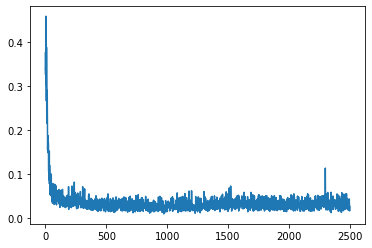

In [12]:
plt.plot(maml.meta_losses)

In [51]:
#defining implementation class
class SineNormal():
    def __init__(self, net, lr, tasks, k):
        self.net=net
        self.k = k
        self.lr=lr
        self.tasks=tasks

        self.criterion=nn.MSELoss()
        self.optim = torch.optim.SGD(self.net.parameters(), self.lr)
        
        self.losses = []

        self.plot_every =10
        self.print_every = 500
  
    def train(self,num_epochs):
        total_loss=0
        for epoch in range(1,num_epochs+1):
            x, y = task.sample_data(size=self.k) #sampling D
            x = x.to(device)
            y = y.to(device)
            
            self.optim.zero_grad()
            out = self.net(x)
            loss = self.criterion(out, y)
            loss.backward()
            self.optim.step()
            
            
            
            ###############
            total_loss+=loss
            if epoch % self.print_every == 0:
                print("{}/{}. loss: {}".format(epoch, num_epochs, total_loss / self.plot_every))
            if epoch%self.plot_every==0:
                self.losses.append(total_loss/self.plot_every)
                total_loss = 0
            if (epoch%100)==0:
                print("Epoch "+str(epoch)+" completed.")

In [52]:
normal_net = SineNet_normal()
normal_net = normal_net.to(device)
normal_trained = SineNormal(normal_net, lr=0.001, tasks=sine_tasks, k=10)

In [70]:
normal_trained.train(100000)

Epoch 100 completed.
Epoch 200 completed.
Epoch 300 completed.
Epoch 400 completed.
500/100000. loss: 0.5198997259140015
Epoch 500 completed.
Epoch 600 completed.
Epoch 700 completed.
Epoch 800 completed.
Epoch 900 completed.
1000/100000. loss: 0.35665932297706604
Epoch 1000 completed.
Epoch 1100 completed.
Epoch 1200 completed.
Epoch 1300 completed.
Epoch 1400 completed.
1500/100000. loss: 0.2675498127937317
Epoch 1500 completed.
Epoch 1600 completed.
Epoch 1700 completed.
Epoch 1800 completed.
Epoch 1900 completed.
2000/100000. loss: 0.19284062087535858
Epoch 2000 completed.
Epoch 2100 completed.
Epoch 2200 completed.
Epoch 2300 completed.
Epoch 2400 completed.
2500/100000. loss: 0.1316249817609787
Epoch 2500 completed.
Epoch 2600 completed.
Epoch 2700 completed.
Epoch 2800 completed.
Epoch 2900 completed.
3000/100000. loss: 0.08701416105031967
Epoch 3000 completed.
Epoch 3100 completed.
Epoch 3200 completed.
Epoch 3300 completed.
Epoch 3400 completed.
3500/100000. loss: 0.0684189349

Epoch 26900 completed.
27000/100000. loss: 0.0018508505309000611
Epoch 27000 completed.
Epoch 27100 completed.
Epoch 27200 completed.
Epoch 27300 completed.
Epoch 27400 completed.
27500/100000. loss: 0.00192437251098454
Epoch 27500 completed.
Epoch 27600 completed.
Epoch 27700 completed.
Epoch 27800 completed.
Epoch 27900 completed.
28000/100000. loss: 0.0006273302133195102
Epoch 28000 completed.
Epoch 28100 completed.
Epoch 28200 completed.
Epoch 28300 completed.
Epoch 28400 completed.
28500/100000. loss: 0.0013890228001400828
Epoch 28500 completed.
Epoch 28600 completed.
Epoch 28700 completed.
Epoch 28800 completed.
Epoch 28900 completed.
29000/100000. loss: 0.001092510181479156
Epoch 29000 completed.
Epoch 29100 completed.
Epoch 29200 completed.
Epoch 29300 completed.
Epoch 29400 completed.
29500/100000. loss: 0.0015490883961319923
Epoch 29500 completed.
Epoch 29600 completed.
Epoch 29700 completed.
Epoch 29800 completed.
Epoch 29900 completed.
30000/100000. loss: 0.0013758825371041

Epoch 53100 completed.
Epoch 53200 completed.
Epoch 53300 completed.
Epoch 53400 completed.
53500/100000. loss: 0.0007314880494959652
Epoch 53500 completed.
Epoch 53600 completed.
Epoch 53700 completed.
Epoch 53800 completed.
Epoch 53900 completed.
54000/100000. loss: 0.001172911492176354
Epoch 54000 completed.
Epoch 54100 completed.
Epoch 54200 completed.
Epoch 54300 completed.
Epoch 54400 completed.
54500/100000. loss: 0.0007489716517738998
Epoch 54500 completed.
Epoch 54600 completed.
Epoch 54700 completed.
Epoch 54800 completed.
Epoch 54900 completed.
55000/100000. loss: 0.00041021103970706463
Epoch 55000 completed.
Epoch 55100 completed.
Epoch 55200 completed.
Epoch 55300 completed.
Epoch 55400 completed.
55500/100000. loss: 0.0002627765934448689
Epoch 55500 completed.
Epoch 55600 completed.
Epoch 55700 completed.
Epoch 55800 completed.
Epoch 55900 completed.
56000/100000. loss: 0.0007824956555850804
Epoch 56000 completed.
Epoch 56100 completed.
Epoch 56200 completed.
Epoch 56300 

Epoch 79200 completed.
Epoch 79300 completed.
Epoch 79400 completed.
79500/100000. loss: 0.00020470410527195781
Epoch 79500 completed.
Epoch 79600 completed.
Epoch 79700 completed.
Epoch 79800 completed.
Epoch 79900 completed.
80000/100000. loss: 0.0003402625152375549
Epoch 80000 completed.
Epoch 80100 completed.
Epoch 80200 completed.
Epoch 80300 completed.
Epoch 80400 completed.
80500/100000. loss: 0.0005903102573938668
Epoch 80500 completed.
Epoch 80600 completed.
Epoch 80700 completed.
Epoch 80800 completed.
Epoch 80900 completed.
81000/100000. loss: 0.0002936911769211292
Epoch 81000 completed.
Epoch 81100 completed.
Epoch 81200 completed.
Epoch 81300 completed.
Epoch 81400 completed.
81500/100000. loss: 0.0005531738861463964
Epoch 81500 completed.
Epoch 81600 completed.
Epoch 81700 completed.
Epoch 81800 completed.
Epoch 81900 completed.
82000/100000. loss: 0.0003912230604328215
Epoch 82000 completed.
Epoch 82100 completed.
Epoch 82200 completed.
Epoch 82300 completed.
Epoch 82400

In [71]:
def test(og_net,x,y,lr,optim=torch.optim.SGD):
    axis=np.linspace(-5,5,1000)
    axis=torch.tensor(axis,dtype=torch.float)
    axis=axis.to(device)
    dummy_net = nn.Sequential(OrderedDict([
        ('l1', nn.Linear(1,40)),
        ('relu1', nn.ReLU()),
        ('l2', nn.Linear(40,40)),
        ('relu2', nn.ReLU()),
        ('l3', nn.Linear(40,1))
    ]))
    dummy_net=dummy_net.to(device)
    sd = og_net.state_dict()
    for k in og_net.state_dict():
        if k[:6] == 'alpha.':
            del sd[k]
    dummy_net.load_state_dict(sd)
    loss_fn=nn.MSELoss()
    opt=optim(dummy_net.parameters(),lr=lr)
    num_shots=10
    k=x.shape[0]
    losses=[]
    outputs={}
    for i in range(1):
        out=dummy_net(x)
        loss=loss_fn(out,y)
        losses.append(loss.item())
        dummy_net.zero_grad()
        loss.backward()
        opt.step()

    outputs['minitrained']= dummy_net(axis.view(-1, 1)).detach().cpu().clone().numpy()
    outputs['initial']= og_net[:5](torch.tensor(axis).view(-1, 1)).detach().cpu().clone().numpy()
    print(losses)
    return outputs,axis


In [72]:
def test(meta_net, normal_net, x, y, lr):
    axis=np.linspace(-5,5,1000)
    axis=torch.tensor(axis,dtype=torch.float)
    axis=axis.to(device)

    
    meta_net_copy = SineNet().cuda()
    meta_net_copy.load_state_dict(meta_net.state_dict())

    normal_net_copy = SineNet_normal().cuda()
    normal_net_copy.load_state_dict(normal_net.state_dict())
    optim = torch.optim.SGD(normal_net_copy.parameters(), lr)

    loss_fn=nn.MSELoss()
    
    theta = OrderedDict((name, param.clone()) for name, param in meta_net_copy.named_parameters())
    
    theta_weights = list(theta[k] for k in theta if not k.startswith('alpha.'))
    theta_names = list(k for k in theta if not k.startswith('alpha.'))
    alpha_weights = list(theta[k] for k in theta if k.startswith('alpha.'))

    x=x.to(device)
    y=y.to(device)

    output_pre = meta_net_copy.argforward(x, theta)
    loss = loss_fn(output_pre, y)
    grads = torch.autograd.grad(loss, theta_weights)
    
    optim.zero_grad()
    out_normal = normal_net_copy(x)
    loss = loss_fn(out_normal, y)
    loss.backward()
    optim.step()
    

    theta_prime = OrderedDict((n, w - a * g) for n, w, a, g in zip(theta_names, theta_weights, alpha_weights, grads))
    
    outputs={}
    outputs['meta_post']= meta_net_copy.argforward(torch.tensor(axis).view(-1, 1), theta_prime).detach().cpu().clone().numpy()
    outputs['meta_pre']= meta_net_copy.argforward(torch.tensor(axis).view(-1, 1), theta).detach().cpu().clone().numpy()
    
    outputs['normal_post']= normal_net_copy(torch.tensor(axis).view(-1, 1)).detach().cpu().clone().numpy()
    outputs['normal_pre']= normal_net(torch.tensor(axis).view(-1, 1)).detach().cpu().clone().numpy()

    return outputs,axis

In [73]:
def plot_test(meta_net, normal_net, x, y, task, lr=0.001):
    outputs,axis=test(meta_net, normal_net, x, y, lr)
    plt.figure(figsize=(10,5))
    plt.plot(axis.cpu().clone().numpy(),task.true_sine(axis.cpu().clone().numpy()), '-', color=(0, 0, 1, 0.5), label='true sine')
    plt.scatter(x.cpu().clone().numpy(), y.cpu().clone().numpy(), label='data')
    plt.plot(axis.cpu().clone().numpy(), outputs['meta_pre'], ':', color=(0.7, 0, 0, 1), label='meta pre')
    plt.plot(axis.cpu().clone().numpy(), outputs['meta_post'], '-', color=(0.5, 0, 0, 1), label='meta post')
    plt.plot(axis.cpu().clone().numpy(), outputs['normal_pre'], ':', color=(0, 0.7, 0, 1), label='norm pre')
    plt.plot(axis.cpu().clone().numpy(), outputs['normal_post'], '-', color=(0, 0.5, 0, 1), label='norm pose')
    plt.legend(loc='lower right')
    plt.show()

C:\Users\Wight\Anaconda3\envs\ThesisMain\lib\site-packages\ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\Wight\Anaconda3\envs\ThesisMain\lib\site-packages\ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\Wight\Anaconda3\envs\ThesisMain\lib\site-packages\ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\Wight\Anaconda3\envs\ThesisMain\lib\site-packages\ipykernel_launcher.py:43: UserWarning: To copy construct from a tensor, it is recommended to use s

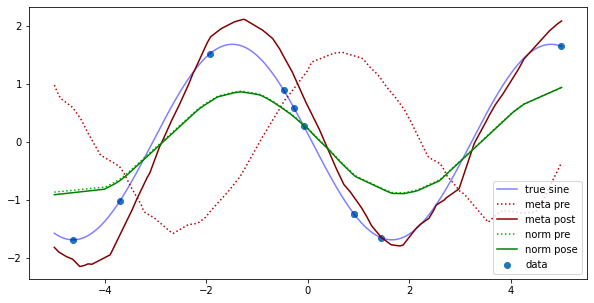

In [74]:
task=sine_tasks.sample_task()
x,y=task.sample_data(K)
x=x.to(device)
y=y.to(device)
plot_test(meta_net=maml.net, normal_net=normal_trained.net, x=x, y=y, task=task)

In [17]:
# maml.net.net.alpha.items()
